In [ ]:
pip install pyspark==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764003 sha256=44bf21c77fd3fd7e283f34be2da5579c2f214cf8f86bda6ca5b950bf8c83772c
  Stored in directory: /root/.cache/pip/wheels/81/9c/6c/d5200fcf351ffa39cbe09911e99703283624cd037df58070d9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [ ]:
pip install findspark

In [ ]:
pip install matplotlib

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [ ]:
# TUGAS 1
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [ ]:
# TUGAS 2
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [ ]:
# Rata-rata Gaji per Departemen
spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
''').show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [ ]:
# Karyawan dengan Gaji di Atas Rata-Rata Berdasarkan Gender
avg_salary_by_gender = spark.sql('''
SELECT Gender, AVG(Salary) as AvgSalary
FROM employees
GROUP BY Gender
''')

spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (SELECT Gender, AVG(Salary) as AvgSalary FROM employees GROUP BY Gender) avg
ON e.Gender = avg.Gender
WHERE e.Salary > avg.AvgSalary
''').show()

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [ ]:
# Ranking Karyawan Berdasarkan Gaji dalam Departemen
spark.sql('''
SELECT Name, DeptId, Salary,
       DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

+-----+------+------+----------+
| Name|DeptId|Salary|SalaryRank|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [ ]:
# TUGAS 3
spark.sql('''
SELECT Name, Age, Salary, rank
FROM (
    SELECT Name, Age, Salary,
           ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
    FROM employees
) ranked_employees
WHERE rank <= 3
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [ ]:
# TUGAS 4
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [ ]:
# TUGAS 5
spark.sql('''
WITH avg_salary AS (
    SELECT DeptId, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY DeptId
)
SELECT e.Name, e.Salary, d.DeptName, avg_s.AvgSalary,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) as SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN avg_salary avg_s ON e.DeptId = avg_s.DeptId
''').show()

+-----+------+---------+---------+----------+
| Name|Salary| DeptName|AvgSalary|SalaryRank|
+-----+------+---------+---------+----------+
|James|  3000|       HR|   2850.0|         1|
|  Lee|  2700|       HR|   2850.0|         2|
| Anna|  4100|Marketing|   4100.0|         1|
+-----+------+---------+---------+----------+



In [ ]:
# TUGAS 6
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptName,
       LAG(e.Salary, 1) OVER (PARTITION BY e.DeptId ORDER BY e.Age) as PreviousSalary,
       e.Salary - LAG(e.Salary, 1) OVER (PARTITION BY e.DeptId ORDER BY e.Age) as SalaryChange
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+---+------+---------+--------------+------------+
| Name|Age|Salary| DeptName|PreviousSalary|SalaryChange|
+-----+---+------+---------+--------------+------------+
|  Lee| 23|  2700|       HR|          null|        null|
|James| 34|  3000|       HR|          2700|         300|
| Anna| 28|  4100|Marketing|          null|        null|
+-----+---+------+---------+--------------+------------+



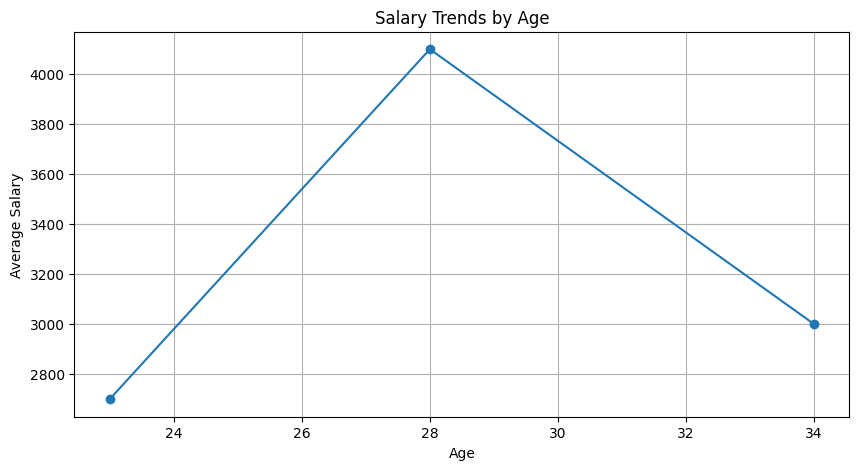

In [ ]:
# TUGAS 7
import matplotlib.pyplot as plt
import pandas as pd

salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

plt.figure(figsize=(10, 5))

plt.plot(salary_trends['Age'].to_numpy(), salary_trends['AverageSalary'].to_numpy(), marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Inisialisasi Spark
spark = SparkSession.builder.appName('SalaryAnalysis').getOrCreate()

# Membuat DataFrame employees
data_employees = [
    Row(Name='James', Age=34, Gender='M', Salary=3000, DeptId=1),
    Row(Name='Anna', Age=28, Gender='F', Salary=4100, DeptId=2),
    Row(Name='Lee', Age=23, Gender='M', Salary=2700, DeptId=1),
    Row(Name='David', Age=24, Gender='M', Salary=2800, DeptId=1),
    Row(Name='Sarah', Age=28, Gender='F', Salary=4500, DeptId=2),
    Row(Name='Peter', Age=34, Gender='M', Salary=3200, DeptId=1),
    Row(Name='Nancy', Age=28, Gender='F', Salary=3800, DeptId=2)
]

employees = spark.createDataFrame(data_employees)
employees.createOrReplaceTempView('employees')

# Membuat DataFrame departments
data_departments = [
    Row(DeptId=1, DeptName='HR'),
    Row(DeptId=2, DeptName='Marketing')
]

departments = spark.createDataFrame(data_departments)
departments.createOrReplaceTempView('departments')

# Menampilkan DataFrame employees dan departments
employees.show()
departments.show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
|David| 24|     M|  2800|     1|
|Sarah| 28|     F|  4500|     2|
|Peter| 34|     M|  3200|     1|
|Nancy| 28|     F|  3800|     2|
+-----+---+------+------+------+

+------+---------+
|DeptId| DeptName|
+------+---------+
|     1|       HR|
|     2|Marketing|
+------+---------+



<Figure size 1000x500 with 0 Axes>

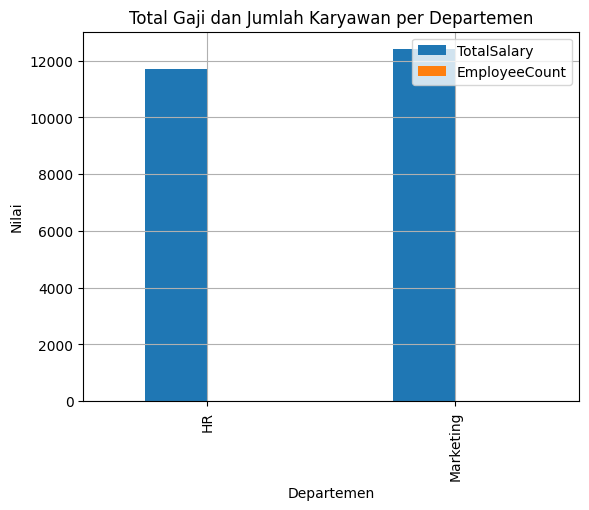

In [ ]:
# TUGAS HOMEWORK 1
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('SalaryAnalysis').getOrCreate()

from pyspark.sql import Row

data_employees = [
    Row(Name='James', Age=34, Gender='M', Salary=3000, DeptId=1),
    Row(Name='Anna', Age=28, Gender='F', Salary=4100, DeptId=2),
    Row(Name='Lee', Age=23, Gender='M', Salary=2700, DeptId=1),
    Row(Name='David', Age=24, Gender='M', Salary=2800, DeptId=1),
    Row(Name='Sarah', Age=28, Gender='F', Salary=4500, DeptId=2),
    Row(Name='Peter', Age=34, Gender='M', Salary=3200, DeptId=1),
    Row(Name='Nancy', Age=28, Gender='F', Salary=3800, DeptId=2)
]
employees = spark.createDataFrame(data_employees)
employees.createOrReplaceTempView('employees')

# Create departments DataFrame and view
data_departments = [
    Row(DeptId=1, DeptName='HR'),
    Row(DeptId=2, DeptName='Marketing')
]
departments = spark.createDataFrame(data_departments)
departments.createOrReplaceTempView('departments')


# Total gaji dan jumlah karyawan per departemen
dept_salary_count = spark.sql('''
    SELECT d.DeptName, SUM(e.Salary) AS TotalSalary, COUNT(e.Name) AS EmployeeCount
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    GROUP BY d.DeptName
''').toPandas()

# Visualisasi perbandingan antar departemen
plt.figure(figsize=(10, 5))
dept_salary_count.plot(x='DeptName', y=['TotalSalary', 'EmployeeCount'], kind='bar')
plt.title('Total Gaji dan Jumlah Karyawan per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Nilai')
plt.grid(True)
plt.show()

In [ ]:
# TUGAS HOMEWORK 2
import pandas as pd

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Robert', 34, 'M', 3600, 2),
    ('Sophia', 28, 'F', 3800, 1),
    ('David', 23, 'M', 2500, 3),
    ('Maria', 40, 'F', 5000, 2),
    ('Tom', 40, 'M', 4800, 3)
]

columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

df = pd.DataFrame(data, columns=columns)

age_salary_avg = df.groupby('Age')['Salary'].mean().reset_index()

df = df.merge(age_salary_avg, on='Age', suffixes=('', '_Avg'))

above_avg_salary = df[df['Salary'] > df['Salary_Avg']]

above_avg_salary

,Name,Age,Gender,Salary,DeptId,Salary_Avg
1,Anna,28,F,4100,2,3950.0
2,Lee,23,M,2700,1,2600.0
3,Robert,34,M,3600,2,3300.0
6,Maria,40,F,5000,2,4900.0


<Figure size 1000x500 with 0 Axes>

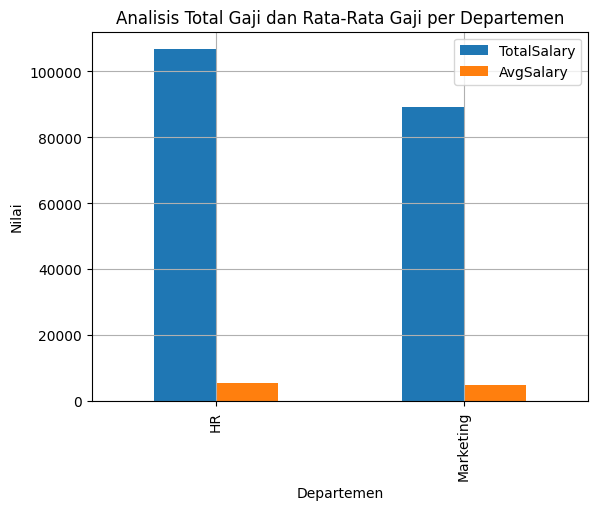

In [ ]:
# TUGAS HOMNEWORK 3
import random
import pandas as pd

# Membuat dataset lebih besar (100+ baris)
random_data = [(f'Employee_{i}', random.randint(20, 60), random.choice(['M', 'F']), random.randint(2000, 8000), random.randint(1, 5)) for i in range(1, 101)]
big_df = spark.createDataFrame(random_data, ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
big_df.createOrReplaceTempView('big_employees')

# Contoh analisis mendalam
big_analysis = spark.sql('''
    SELECT d.DeptName, SUM(e.Salary) AS TotalSalary, AVG(e.Salary) AS AvgSalary, COUNT(e.Name) AS EmployeeCount
    FROM big_employees e
    JOIN departments d ON e.DeptId = d.DeptId
    GROUP BY d.DeptName
''').toPandas()

# Visualisasi hasil analisis
plt.figure(figsize=(10, 5))
big_analysis.plot(x='DeptName', y=['TotalSalary', 'AvgSalary'], kind='bar')
plt.title('Analisis Total Gaji dan Rata-Rata Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Nilai')
plt.grid(True)
plt.show()